# Implement a Conversational AI chatbot which can interact with users in natural language form.

Pre-requisites:
- Download and install OLLAMA locally (install MISTRAL and SQLCoder)
- Python 3.12

In [2]:
import sqlite3
from datetime import datetime, timedelta
import random
import requests
import functools
import time
import re
import pandas as pd
import gradio as gr
import threading
from sklearn.metrics import precision_recall_fscore_support
from bert_score import score

### Prepare entities: valid entities used to extract info and answer user queries.
### Store all the relevant information in a database

In [2]:
# Initialize SQLite database
conn = sqlite3.connect('ecommerce_data.db')
cursor = conn.cursor()

# Create a single table for all banking data
cursor.execute('''
CREATE TABLE IF NOT EXISTS ecommerce_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id TEXT,
    name TEXT,
    city TEXT,
    product_category TEXT,
    product_name TEXT,
    price REAL,
    quantity INTEGER,
    order_date TEXT
)
''')

# Sample data for randomization
product_categories = ['Electronics', 'Clothing', 'Books', 'Home & Garden', 'Toys']
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix']
product_names = {
    'Electronics': ['Smartphone', 'Laptop', 'Headphones', 'Tablet', 'Smart Watch'],
    'Clothing': ['T-shirt', 'Jeans', 'Dress', 'Jacket', 'Sneakers'],
    'Books': ['Fiction Novel', 'Cookbook', 'Biography', 'Self-Help Book', 'Textbook'],
    'Home & Garden': ['Coffee Maker', 'Bedding Set', 'Indoor Plant', 'Wall Art', 'Kitchen Utensils'],
    'Toys': ['LEGO Set', 'Board Game', 'Action Figure', 'Puzzle', 'Remote Control Car']
}

def generate_ecommerce_data():
    """
    Generate sample e-commerce data for 5 users, each with 10 orders.
    """
    data = []
    for i in range(1, 6):  # Generate 5 users
        user_id = f'USER{i:05d}'
        name = f'Customer {i}'
        city = random.choice(cities)
        
        # Generate 10 orders for each user
        for _ in range(10):
            product_category = random.choice(product_categories)
            product_name = random.choice(product_names[product_category])
            price = round(random.uniform(10, 500), 2)
            quantity = random.randint(1, 5)
            order_date = (datetime.now() - timedelta(days=random.randint(1, 365))).strftime('%Y-%m-%d')
            data.append((user_id, name, city, product_category, product_name, price, quantity, order_date))
    
    return data

# Generate and insert data
ecommerce_data = generate_ecommerce_data()
cursor.executemany('''
INSERT INTO ecommerce_data 
(user_id, name, city, product_category, product_name, price, quantity, order_date) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?)
''', ecommerce_data)

# Commit the changes to the database
conn.commit()

print(f"Inserted {len(ecommerce_data)} records into the ecommerce_data table.")

# Verify the data by selecting and printing the first 10 rows
cursor.execute("SELECT * FROM ecommerce_data LIMIT 10")
print("\nSample E-commerce Data:")
for row in cursor.fetchall():
    print(row)

# Close the database connection
conn.close()

print("\nData initialization complete.")

Inserted 50 records into the ecommerce_data table.

Sample E-commerce Data:
(1, 'USER00001', 'Customer 1', 'Phoenix', 'Clothing', 'Dress', 132.53, 3, '2024-02-23')
(2, 'USER00001', 'Customer 1', 'Phoenix', 'Home & Garden', 'Indoor Plant', 392.39, 2, '2024-07-17')
(3, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Puzzle', 463.15, 2, '2024-04-22')
(4, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Action Figure', 117.05, 4, '2023-12-20')
(5, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Textbook', 51.93, 5, '2024-01-09')
(6, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Action Figure', 48.27, 5, '2024-05-02')
(7, 'USER00001', 'Customer 1', 'Phoenix', 'Clothing', 'Sneakers', 395.16, 1, '2024-05-19')
(8, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Board Game', 47.81, 1, '2024-05-22')
(9, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Self-Help Book', 303.13, 1, '2024-03-06')
(10, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Textbook', 434.17, 3, '2023-09-26')

Data initializatio

In [3]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('ecommerce_data.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Execute a SELECT query to fetch all rows from the banking_data table
cursor.execute("SELECT * FROM ecommerce_data")

# Fetch all the results and print each row
for row in cursor.fetchall():
    print(row)

# Close the cursor and connection
conn.close()

(1, 'USER00001', 'Customer 1', 'Phoenix', 'Clothing', 'Dress', 132.53, 3, '2024-02-23')
(2, 'USER00001', 'Customer 1', 'Phoenix', 'Home & Garden', 'Indoor Plant', 392.39, 2, '2024-07-17')
(3, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Puzzle', 463.15, 2, '2024-04-22')
(4, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Action Figure', 117.05, 4, '2023-12-20')
(5, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Textbook', 51.93, 5, '2024-01-09')
(6, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Action Figure', 48.27, 5, '2024-05-02')
(7, 'USER00001', 'Customer 1', 'Phoenix', 'Clothing', 'Sneakers', 395.16, 1, '2024-05-19')
(8, 'USER00001', 'Customer 1', 'Phoenix', 'Toys', 'Board Game', 47.81, 1, '2024-05-22')
(9, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Self-Help Book', 303.13, 1, '2024-03-06')
(10, 'USER00001', 'Customer 1', 'Phoenix', 'Books', 'Textbook', 434.17, 3, '2023-09-26')
(11, 'USER00002', 'Customer 2', 'New York', 'Clothing', 'T-shirt', 374.78, 4, '2024-02-07')
(12

### Chatbot system implementation: Implement a chatbot system which takes user queries and provides relevant answers to them.
### Prepare Intents: At least 4 Tasks/Query types that can be handled by chatbot

In [4]:
# Thread-local storage for SQLite connections
local_storage = threading.local()

def get_db_connection():
    """
    Get or create a thread-local SQLite connection.
    This ensures each thread has its own database connection.
    """
    if not hasattr(local_storage, "connection"):
        local_storage.connection = sqlite3.connect('ecommerce_data.db')
    return local_storage.connection

# Caching decorator to improve performance
def cache(func):
    """
    Decorator to cache function results.
    This can significantly speed up repeated calls with the same arguments.
    """
    cache_dict = {}
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in cache_dict:
            cache_dict[key] = func(*args, **kwargs)
        return cache_dict[key]
    return wrapper

@cache
def ollama_chat(prompt, model="mistral"):
    """
    Interact with the Ollama API to generate responses.
    
    :param prompt: The input prompt for the model
    :param model: The model to use (default is "mistral")
    :return: The generated response or an error message
    """
    url = "http://localhost:11434/api/generate"
    data = {
        "model": model,
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, json=data)
    if response.status_code == 200:
        return response.json()['response']
    else:
        return f"Error: {response.status_code} - {response.text}"

@cache
def generate_sql(natural_language_query):
    """
    Generate an SQL query from a natural language question using the SQLCoder model.
    
    :param natural_language_query: The user's question in natural language
    :return: A generated SQL query or an error message
    """
    # Prompt for SQL generation
    prompt = f"""
    Table: ecommerce_data
    Columns: id, user_id, name, city, product_category, product_name, price, quantity, order_date

    Here are a few examples of SQLite queries:

    Question: Show the total spent by user USER#####
    SQLite Query: SELECT user_id, SUM(price * quantity) AS total_spent FROM ecommerce_data WHERE user_id = 'USER#####' GROUP BY user_id;

    Question: What are the last 5 orders for user USER#####?
    SQLite Query: SELECT order_date, product_name, quantity, price FROM ecommerce_data WHERE user_id = 'USER#####' ORDER BY order_date DESC LIMIT 5;

    Question: Show the average order value for each product category
    SQLite Query: SELECT product_category, AVG(price * quantity) as avg_order_value FROM ecommerce_data GROUP BY product_category;

    Question: Show all orders from New York City
    SQLite Query: SELECT * FROM ecommerce_data WHERE lower(city) LIKE lower('%New York%') LIMIT 5;

    Question: What are the top 3 most expensive orders?
    SQLite Query: SELECT * FROM ecommerce_data ORDER BY (price * quantity) DESC LIMIT 3;

    Question: Customer name who have product from category Clothing
    SQLite Query: SELECT name FROM ecommerce_data WHERE product_category = 'Clothing';

    Now, generate a SQLite query to answer the following question:
    {natural_language_query}

    Rules:
    1. Use SQLite syntax. Remember, SQLite doesn't support ILIKE, use LIKE with lower() for case-insensitive matching.
    2. Return ONLY the SQL query without any explanation, comments, or additional text.
    3. Do not include any numbering, question text, or prefixes before the SQL query.
    4. Ensure the query is complete, executable, and starts with an appropriate SQL keyword (SELECT, INSERT, UPDATE, etc.).
    5. Use appropriate aggregations, joins, or subqueries as needed.
    6. Limit results to 5 rows unless specified otherwise.
    7. Do not include any markdown formatting or code block syntax.
    8. End the query with a semicolon.

    SQL Query:
    """
    
    try:
        sql_query = ollama_chat(prompt, model="sqlcoder")
        # Clean up the query
        sql_query = clean_sql_query(sql_query)
        return sql_query
    except Exception as e:
        return f"Error generating SQL: {str(e)}"

def clean_sql_query(query):
    """
    Clean and format the generated SQL query.
    
    :param query: The raw SQL query
    :return: A cleaned and formatted SQL query
    """
    # Remove any markdown code block syntax
    query = re.sub(r'```sql|```', '', query)
    # Remove any leading/trailing whitespace
    query = query.strip()
    # Remove any HTML-like tags
    query = re.sub(r'<.*?>', '', query)
    # Remove numbering at the start
    query = re.sub(r'^\d+\.\s*', '', query)
    # Remove any text before the actual SQL query
    query = re.sub(r'^.*?(SELECT|INSERT|UPDATE|DELETE|CREATE|ALTER|DROP)', r'\1', query, flags=re.IGNORECASE)
    # Replace ILIKE with LIKE and lower() for case-insensitive matching
    query = re.sub(r'ILIKE\s+([\'"]%.*?%[\'"])', r"LIKE lower(\1)", query, flags=re.IGNORECASE)
    query = re.sub(r'ILIKE', "LIKE", query, flags=re.IGNORECASE)
    # Ensure the query ends with a semicolon
    if not query.endswith(';'):
        query += ';'
    return query

def execute_query(query):
    """
    Execute an SQL query and format the results.
    
    :param query: The SQL query to execute
    :return: Formatted query results or an error message
    """
    try:
        conn = get_db_connection()
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        if not results:
            return "No results found."
        
        columns = [description[0] for description in cursor.description]
        formatted_results = "Query results:\n"
        for row in results[:5]:  # Limit to first 5 rows
            formatted_results += ", ".join([f"{col}: {val}" for col, val in zip(columns, row)]) + "\n"
        
        if len(results) > 5:
            formatted_results += f"... and {len(results) - 5} more rows"
        
        return formatted_results
    except sqlite3.Error as e:
        return f"Error executing SQL query: {str(e)}"

def chatbot_response(user_input):
    """
    Main function to handle user input and generate chatbot responses.
    
    :param user_input: The user's input message
    :return: The chatbot's response with response time
    """
    start_time = time.time()
    
    try:
        if user_input.lower().startswith("sql:"):
            # Handle SQL-related queries
            natural_language_query = user_input[4:].strip()            
            sql_query = generate_sql(natural_language_query)
            print(f"Debug - Generated SQL Query: {sql_query}")  # Debug print
            query_result = execute_query(sql_query)
            
            if query_result.startswith("Error") or query_result == "No results found.":
                # Handle errors or no results
                interpretation_prompt = f"""
                You are a helpful e-commerce assistant. The user asked the following question, but an error occurred or no results were found:

                User's question: {natural_language_query}
                Result: {query_result}

                Please provide a friendly response that:
                1. Acknowledges the issue.
                2. Apologizes for the inconvenience.
                3. Suggests the user try again or rephrase their query.
                4. Offers to help them with any other e-commerce-related questions.

                Response:
                """
            else:
                # Interpret successful query results
                interpretation_prompt = f"""
                You are a helpful e-commerce assistant. You need to interpret the following SQL query and its results, and provide a natural language response to the user's question.

                User's question: {natural_language_query}
                SQL Query: {sql_query}
                Query Result: {query_result}

                Please provide a friendly and informative response based on this information. Do not mention SQL or query details in your response. Simply answer the user's question in a natural way, as if you had direct access to their e-commerce information.

                Response:
                """
            
            response = ollama_chat(interpretation_prompt, model="mistral")
        else:
            # Handle general e-commerce queries
            prompt = f"""
            You are an online AI assistant for an e-commerce platform, designed to help customers with various shopping-related queries and tasks. Your name is ShopBot. You should always be polite, professional, and helpful. For data queries, suggest using the 'sql:' prefix. 

            Here are the types of queries you should be prepared to handle:

            1. Greetings: 
               - Respond to customer greetings warmly.
               - Example: "Hello! Welcome to our online store. How may I assist you today?"

            2. General Inquiries:
               - Provide information about product categories, shipping, returns, etc.
               - Example: "We offer free shipping on orders over $50. How else can I help you?"

            3. Product Inquiries:
               - Help customers find products, check availability, etc.
               - For specific product details, suggest using the 'sql:' prefix.
               - Example: "To check product availability, you can use the 'sql:' prefix to retrieve information, like this: 'sql: Show available quantities for product X'."

            4. Order Assistance:
               - Guide customers on placing orders, tracking shipments, etc.
               - For order history, suggest using the 'sql:' prefix.
               - Example: "For your recent orders, you can use a query like 'sql: Show my last 5 orders'."

            Remember:
            - Always maintain a professional and friendly tone.
            - Protect customer privacy by NEVER asking for sensitive information like full credit card numbers or passwords.
            - For data-specific queries, guide the user to use the 'sql:' prefix.
            - If you're unsure about any information, it's better to suggest contacting customer service or checking the official website.

            Now, please assist the customer with their query:

            Customer: {user_input}
            ShopBot:
            """
            response = ollama_chat(prompt, model="mistral")

    except Exception as e:
        response = "I apologize, but I encountered an error while processing your request. Please try again or contact support if the issue persists."

    # Calculate and append response time
    end_time = time.time()
    response_time = end_time - start_time
    return f"{response}\n\nResponse time: {response_time:.2f} seconds"

### Evaluate performance of your chatbot for different types of questions [at least 10 questions per intent].
    Show respective metrics: precision, recall, f1 score
    Answer to each question


In [5]:
def evaluate_chatbot(questions, expected_answers):
    """
    Evaluate the chatbot's performance by comparing its responses to expected answers.
    
    :param questions: List of input questions
    :param expected_answers: List of expected answers corresponding to the questions
    :return: List of tuples containing (question, response, expected answer)
    """
    results = []
    for question, expected in zip(questions, expected_answers):
        # Get chatbot's response for each question
        response = chatbot_response(question)
        
        # Store the results without user input
        results.append((question, response, expected))
    return results

def calculate_metrics(results):
    """
    Calculate precision, recall, and F1 score based on the evaluation results.
    
    :param results: List of tuples containing evaluation results
    :return: Tuple of (precision, recall, F1 score)
    """
    # Create binary lists for true labels and predictions
    y_true = [1 if r[4] else 0 for r in results]  # 1 if correct, 0 if incorrect
    y_pred = [1] * len(results)  # Assuming the chatbot always gives an answer
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    return precision, recall, f1

In [15]:
# 10 different sample questions per intent
intents = {
    "Greetings": [
        "Hello",
        "Hi there",
        "Good morning",
        "Hey ShopBot",
        "Greetings",
        "Good afternoon",
        "Hi, how are you?",
        "Hello, is anyone there?",
        "Hey, can you help me?",
        "Good evening"
    ],
    "General Enquiry": [
        "What are your shipping options?",
        "Do you offer international shipping?",
        "How can I track my order?",
        "What's your return policy?",
        "Do you have a loyalty program?",
        "How can I contact customer support?",
        "Are there any ongoing sales or promotions?",
        "Do you offer gift wrapping?",
        "What payment methods do you accept?",
        "How do I create an account on your website?"
    ],
    "Product Enquiry": [
        "sql: What's the max price for the product name smartphone?",
        "sql: Show me all products name in the Clothing category",
        "sql: What are the top 3 most expensive product order?",
        "sql: Are there any discounts on electronics?",
        "sql: How many quantity of 'LEGO Set' are sold?",
        "sql: What's the average price of product in the Home & Garden category?",
        "sql: List all products name ordered by the user USER00003",
        "sql: Customer name who have product from category Clothing",
        "sql: Show me the city with lowest purchase price",
        "sql: How many different product categories do you have?"
    ],
    "Order Enquiry": [
        "sql: Show last 5 orders of user id USER00001",
        "sql: What's the largest order this year and by which user?",
        "sql: Show me the last 3 orders for user USER00002",
        "sql: Show me all orders above $500",
        "sql: What are the top 3 largest orders across all users?",
        "sql: When was the last order placed by USER00005?",
        "sql: Show me all orders from last month",
        "sql: hat's the average order value for each user?",
        "sql: How many orders were placed from New York City last year?",
        "sql: Show me all orders for the 'Electronics' category"
    ]
}

# Define expected answers
expected_answers = {
    "Greetings": ["A friendly greeting response"] * 10,
    "General Enquiry": [
        "Information about shipping options",
        "Details on international shipping availability",
        "Instructions for order tracking",
        "Explanation of return policy",
        "Information about loyalty program",
        "Customer support contact information",
        "Current sales and promotions",
        "Gift wrapping service details",
        "Accepted payment methods",
        "Account creation process"
    ],
    "Product Enquiry": [
        "The max price of the smartphone is $17.71.",
        "Products in the Clothing category: Dress, Sneakers, T-shirt, Jeans, and Jacket.",
        "Top 3 most expensive products are: Dress at $1772.55, Biography book at $1763.95, Kitchen Utensils at $1597.24",
        "There is no discount",
        "6 LEGO Sets were sold in total.",
        "Average price of Home & Garden items: approximately $317.20.",
        "Customer 3 ordered: Jeans, Kitchen Utensils, T-shirt, Board Game, Textbook, Biography, LEGO Set, and Sneakers.",
        "Customer 1, 2, 3 and 5",
        "New York",
        "5 product categories: Clothing, Home & Garden, Toys, Books, and Electronics."
    ],
    "Order Enquiry": [
        "USER00001's last 5 orders: Sneakers ($395.16), Board Game ($47.81), Sneakers ($395.16), Action Figure ($48.27), Puzzle ($463.15).",
        "Largest order: $1,772.65 by USER00005 for 5 Dresses on 2024-01-12.",
        "USER00002's last 3 orders: Action Figure ($883.65), Laptop ($84.42), Sneakers ($98.54).",
        "Orders above $500: USER00001 (Textbook $1,302.51), USER00002 (T-shirt $1,499.12), USER00003 (Kitchen Utensils $1,597.24), USER00004 (Biography $1,763.95), USER00005 (Dress $1,772.65).",
        "Top 3 largest orders: USER00005 (Dress $1,772.65), USER00004 (Biography $1,763.95), USER00003 (Kitchen Utensils $1,597.24).",
        "Last order by USER00005: 2024-09-07 for a Textbook.",
        "No orders from 'last month' (most recent order is 2024-09-10).",
        "Average order values: USER00001 ($470.77), USER00002 ($420.35), USER00003 ($326.59), USER00004 ($473.67), USER00005 ($601.40).",
        "6 orders placed from New York in 2023.",
        "Electronics orders: USER00002 (Laptop $84.42), USER00004 (Smartphone $35.42, Headphones $1,060.36, Tablet $824.56)."
    ]
}

# Initialize a dictionary to store results for all intents
all_results = {}

# Iterate through each intent and its associated questions
for intent, questions in intents.items():
    print(f"\nEvaluating {intent}...")
    all_results[intent] = evaluate_chatbot(questions, expected_answers[intent])


Evaluating Greetings...

Evaluating General Enquiry...

Evaluating Product Enquiry...
Debug - Generated SQL Query: SELECT MAX(price) AS max_price FROM ecommerce_data WHERE product_name LIKE lower('%smartphone%')
Debug - Generated SQL Query: SELECT ecommerce_data.product_name FROM ecommerce_data WHERE ecommerce_data.product_category LIKE lower('%Clothing%');
Debug - Generated SQL Query: SELECT * FROM ecommerce_data ORDER BY (price * quantity) DESC LIMIT 3;
Debug - Generated SQL Query: SELECT lower(product_name) FROM ecommerce_data WHERE product_category = 'Electronics' ORDER BY lower(product_name) LIMIT 5;
Debug - Generated SQL Query: SELECT product_category FROM ecommerce_data WHERE product_name LIKE lower('%LEGO%Set%') GROUP BY product_category;
Debug - Generated SQL Query: SELECT AVG(price) AS average_price FROM ecommerce_data WHERE product_category = 'Home & Garden';
Debug - Generated SQL Query: SELECT product_name, price FROM ecommerce_data WHERE user_id = 'USER00003' ORDER BY pro

##### Human Evaluation

In [12]:
# Create a DataFrame to store all results
df_results = pd.DataFrame(columns=['Intent', 'Question', 'Response', 'Expected', 'Correct'])

# Create a list to store all results
results_list = []

# Populate the list and get user input for correctness
for intent, results in all_results.items():
    for question, response, expected in results:
        print(f"\nIntent: {intent}")
        print(f"Q: {question}")
        print(f"A: {response}")
        print(f"Expected: {expected}")
        correct = input("Is this response correct? (y/n): ").lower() == 'y'
        results_list.append({
            'Intent': intent,
            'Question': question,
            'Response': response,
            'Expected': expected,
            'Correct': correct
        })

# Convert the list to a DataFrame after the loop
df_results = pd.concat([df_results, pd.DataFrame(results_list)], ignore_index=True)

# Calculate metrics for each intent
intent_metrics = {}
for intent in intents.keys():
    intent_results = df_results[df_results['Intent'] == intent]
    y_true = intent_results['Correct'].astype(int).tolist()
    y_pred = [1] * len(y_true)  # Assuming the chatbot always gives an answer
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    intent_metrics[intent] = {'Precision': precision, 'Recall': recall, 'F1': f1}

# Print metrics for each intent
print("\nMetrics for each intent:")
for intent, metrics in intent_metrics.items():
    print(f"{intent}:")
    print(f"  Precision: {metrics['Precision']:.2f}")
    print(f"  Recall: {metrics['Recall']:.2f}")
    print(f"  F1 Score: {metrics['F1']:.2f}")

# Calculate overall metrics
overall_y_true = df_results['Correct'].astype(int).tolist()
overall_y_pred = [1] * len(overall_y_true)
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(overall_y_true, overall_y_pred, average='binary')

print("\nOverall Metrics:")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1 Score: {overall_f1:.2f}")

# Analyze entity recognition
# Define the entities we want to track
entities = ["product", "price", "quantity", "date", "city", "user_id", "category", "order"]
# Initialize a dictionary to count occurrences of each entity
entity_recognition = {entity: 0 for entity in entities}

# Count entity occurrences in questions and responses
for _, row in df_results.iterrows():
    for entity in entities:
        # Increment count if entity is found in question or response
        if entity in row['Question'].lower() or entity in row['Response'].lower():
            entity_recognition[entity] += 1

# Print entity recognition results
print("\nEntity Recognition:")
for entity, count in entity_recognition.items():
    print(f"{entity}: {count} occurrences")

# Identify areas for improvement
# Find intents with F1 score below 0.7
low_performing_intents = [intent for intent, metrics in intent_metrics.items() if metrics['F1'] < 0.7]
# Find entities recognized less than 5 times
low_recognized_entities = [entity for entity, count in entity_recognition.items() if count < 5]

# Print areas for improvement
print("\nAreas for Improvement:")
if low_performing_intents:
    print(f"Intents needing improvement: {', '.join(low_performing_intents)}")
if low_recognized_entities:
    print(f"Entities needing better recognition: {', '.join(low_recognized_entities)}")


Intent: Greetings
Q: Hello
A:  Hello! Welcome to our online store. How may I assist you today? If you have any questions about our products, shipping, returns, or other related topics, feel free to ask. To check product availability or your order history, you can use the 'sql:' prefix for a more specific response. For instance, 'sql: Show available quantities for product X' or 'sql: Show my last 5 orders'. If you need further assistance or have any concerns, please don't hesitate to let me know!

Response time: 113.98 seconds
Expected: A friendly greeting response

Intent: Greetings
Q: Hi there
A:  Hello! Welcome to our online store. How may I assist you today? If you have any questions about our products, shipping, returns, or anything else, feel free to ask! We're here to help. To check product availability or for specific details, you can use the 'sql:' prefix in your queries, like this: 'sql: Show available quantities for product X'. For your recent orders, you can use a query lik

##### BERT Evaluation

In [14]:
# Calculate BERT Score for each intent
intent_bert_scores = {}
for intent in df_results['Intent'].unique():
    intent_results = df_results[df_results['Intent'] == intent]
    references = intent_results['Expected'].tolist()
    candidates = intent_results['Response'].tolist()
    P, R, F1 = score(candidates, references, lang="en", verbose=False)
    intent_bert_scores[intent] = {
        'BERT_P': P.mean().item(),
        'BERT_R': R.mean().item(),
        'BERT_F1': F1.mean().item()
    }

# Print BERT Score metrics for each intent
print("\nBERT Score Metrics for each intent:")
for intent, metrics in intent_bert_scores.items():
    print(f"{intent}:")
    print(f"  BERT Precision: {metrics['BERT_P']:.4f}")
    print(f"  BERT Recall: {metrics['BERT_R']:.4f}")
    print(f"  BERT F1 Score: {metrics['BERT_F1']:.4f}")

# Calculate overall BERT Score
overall_references = df_results['Expected'].tolist()
overall_candidates = df_results['Response'].tolist()
overall_P, overall_R, overall_F1 = score(overall_candidates, overall_references, lang="en", verbose=False)

print("\nOverall BERT Score Metrics:")
print(f"BERT Precision: {overall_P.mean().item():.4f}")
print(f"BERT Recall: {overall_R.mean().item():.4f}")
print(f"BERT F1 Score: {overall_F1.mean().item():.4f}")

# Identify intents needing improvement based on BERT Score
low_performing_intents = [intent for intent, metrics in intent_bert_scores.items() if metrics['BERT_F1'] < 0.7]

print("\nAreas for Improvement based on BERT Score:")
if low_performing_intents:
    print(f"Intents needing improvement: {', '.join(low_performing_intents)}")
else:
    print("All intents are performing well according to BERT Score.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro


BERT Score Metrics for each intent:
Greetings:
  BERT Precision: 0.7828
  BERT Recall: 0.8507
  BERT F1 Score: 0.8153
General Enquiry:
  BERT Precision: 0.7802
  BERT Recall: 0.8541
  BERT F1 Score: 0.8153
Product Enquiry:
  BERT Precision: 0.8151
  BERT Recall: 0.8892
  BERT F1 Score: 0.8504
Order Enquiry:
  BERT Precision: 0.8091
  BERT Recall: 0.8686
  BERT F1 Score: 0.8376


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Overall BERT Score Metrics:
BERT Precision: 0.7968
BERT Recall: 0.8657
BERT F1 Score: 0.8297

Areas for Improvement based on BERT Score:
All intents are performing well according to BERT Score.


### Build a UI using which user can interact with chatbot

In [6]:
def chat_interface(message, history):
    """
    Function to process user messages and return chatbot responses.
    
    :param message: User's input message
    :param history: Chat history (not used in this implementation)
    :return: Chatbot's response
    """
    response = chatbot_response(message)
    return response

# Create Gradio interface
iface = gr.ChatInterface(
    chat_interface,
    chatbot=gr.Chatbot(height=500),  # Chat display area
    textbox=gr.Textbox(
        placeholder="Type your message here...",
        container=False,
        scale=7
    ),  # Input text box
    title="E-commerce Assistant",  # Title of the interface
    description="Welcome to our online store! How can I assist you today?",  # Description/welcome message
    theme="soft",  # UI theme
    examples=[  # Example queries for users to try
        "Hello, I need help finding a product.",
        "What are your shipping options?",
        "sql: Show me the latest electronics products",
        "sql: What were my last 3 orders?",
        "How can I return an item?",
        "sql: What's the average price of items in the Clothing category?",
        "Do you offer gift wrapping?",
        "sql: Show me the top 5 bestselling products",
        "What's your return policy?",
        "sql: What's the total value of purchases this year for user USER00002?"
    ],
    cache_examples=True,  # Cache example outputs
    retry_btn="Try Again",  # Add a retry button
    undo_btn="Undo",  # Label for undo button
    clear_btn="Clear Chat",  # Label for clear button
)

# Launch the interface
if __name__ == "__main__":
    iface.launch(share=False, debug=True)  # Launch in debug mode and create a shareable link

Caching examples at: 'c:\Users\soore\Folders\BITS\Sem_3\Con_AI\01_Code\Assignment_2\gradio_cached_examples\16'
Caching example 1/10
Caching example 2/10
Caching example 3/10
Debug - Generated SQL Query: SELECT product_name FROM ecommerce_data WHERE product_category = 'Electtronics' ORDER BY order_date DESC LIMIT 5;
Caching example 4/10
Debug - Generated SQL Query: SELECT order_date, product_name, quantity, price FROM ecommerce_data WHERE user_id = 'USER#####' ORDER BY order_date DESC LIMIT 3;
Caching example 5/10
Caching example 6/10
Debug - Generated SQL Query: SELECT product_category, AVG(price * quantity) AS avg_order_value FROM ecommerce_data WHERE product_category = 'Clothing' GROUP BY product_category;
Caching example 7/10
Caching example 8/10
Debug - Generated SQL Query: -----------------------------------------------------

    PREQUISite: SELECT product_name, COUNT(*) AS sales_count FROM ecommerce_data GROUP BY product_name ORDER BY sales_count DESC LIMIT 5;
Caching example 9/

Debug - Generated SQL Query: SELECT product_category, AVG(price * quantity) AS avg_order_value FROM ecommerce_data WHERE product_category = 'Clothing' GROUP BY product_category;
Keyboard interruption in main thread... closing server.


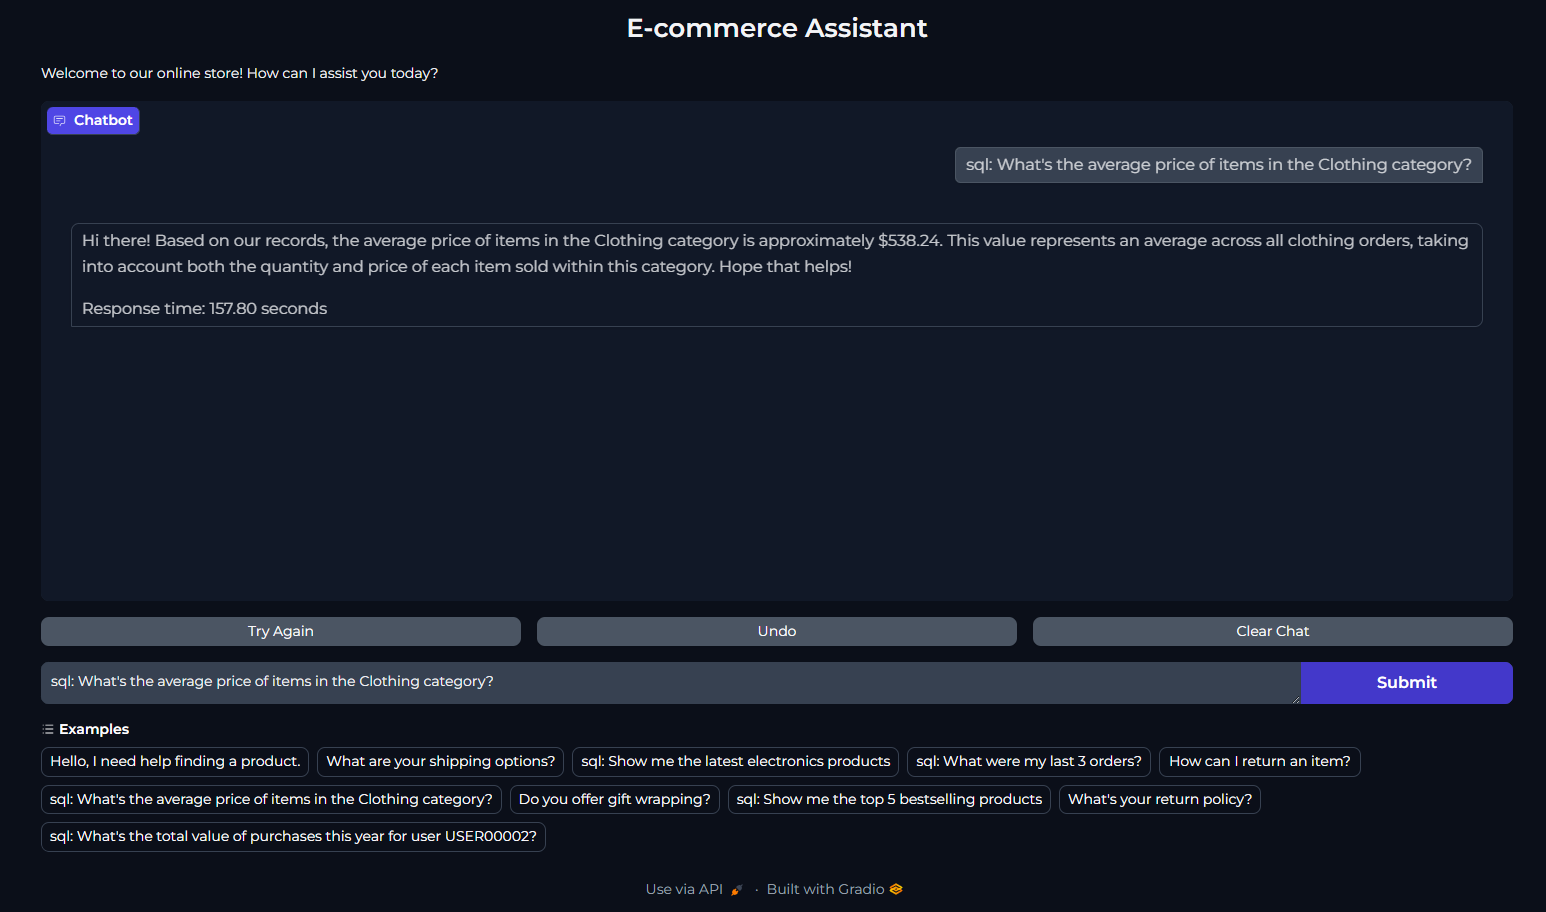